In [2]:
import os
import gzip
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import statsmodels.api as sm
import sklearn.preprocessing
import scipy.sparse
import sklearn.metrics
import sklearn.mixture
import sklearn.linear_model
from anndata import AnnData
sc.settings.set_figure_params(dpi=100)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
%load_ext rpy2.ipython
sns.set(font_scale=1.5)
plt.style.use('seaborn-white')

# Read depth distribution

In [ ]:
import sklearn.mixture

sample_name = 'nPOD4-wt-merged'
wd = '/oasis/tscc/scratch/jchiou42/nPOD_snATAC/{}'.format(sample_name)

qc = pd.read_table(os.path.join(wd, '{}.qc_metrics.txt'.format(sample_name)), sep='\t', header=0, index_col=0)
qc['log10_unique_usable_reads'] = np.log10(qc['unique_usable_reads']+1)
qc = qc.sort_values('log10_unique_usable_reads')
gmm = sklearn.mixture.GaussianMixture(n_components=2, random_state=0).fit(qc[['log10_unique_usable_reads']])
pp = gmm.predict_proba(qc[['log10_unique_usable_reads']])
qc['low'] = [pp[i][0] for i in range(len(pp))]
qc['high'] = [pp[i][1] for i in range(len(pp))]

plt.style.use('seaborn-white')
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
ax1.hist(qc.loc[qc['low']>=.99, 'log10_unique_usable_reads'], color='red', bins=np.arange(0,5,.05), alpha=.5, label='_nolegend_')
ax1.hist(qc.loc[qc['high']>=.99, 'log10_unique_usable_reads'], color='green', bins=np.arange(0,5,.05), alpha=.5, label='_nolegend_')
ax1.hist(qc.loc[(qc['high']<.99) & (qc['low']<.99), 'log10_unique_usable_reads'], color='lightgrey', bins=np.arange(0,5,.05), alpha=.5, label='_nolegend_')
ax1.axvline(np.log10(500), color='black', label='500')
ax1.axvline(np.log10(1000), color='blue', label='1000')
ax1.axvline(qc.loc[qc['high']>=.99, 'log10_unique_usable_reads'].median(), color='green', label='Median\n({})'.format(int(10**qc.loc[qc['high']>=.99, 'log10_unique_usable_reads'].median())))
ax1.set_ylim(0,1000)
ax1.set_ylabel('count')
ax1.set_xlabel('log10(read depth)')
ax1.legend()
plt.show()

# Run one individual sample

In [31]:
sample_name = 'A0016'
wd = '/home/joshchiou/joshchiou-data2/biobank_snATAC/{}'.format(sample_name)
sp = scipy.io.mmread(os.path.join(wd, '{}.mtx.gz'.format(sample_name))).tocsr()
regions = open(os.path.join(wd, '{}.regions'.format(sample_name))).read().splitlines()
barcodes = open(os.path.join(wd, '{}.barcodes'.format(sample_name))).read().splitlines()
adata = AnnData(sp, {'obs_names':barcodes}, {'var_names':regions})

metrics = pd.read_table(os.path.join(wd, '{}.qc_metrics.txt'.format(sample_name)), sep='\t', header=0, index_col=0)
adata.obs = adata.obs.join(metrics, how='inner')
#low_frip = open(os.path.join(wd, '{}.lowfrip'.format(sample_name))).read().splitlines()
#adata = adata[(~adata.obs.index.isin(low_frip)),:].copy()

promoters = pd.read_table('/home/joshchiou/references/gencode.v19.5kb_promoter_names.txt', sep='\t', header=None, index_col=0, names=['prom'])
promoter_names = promoters['prom'].to_dict()
adata.var.index = [promoter_names[b] if b in promoter_names else b for b in adata.var.index]
adata.var_names_make_unique(join='.')
adata.raw = sc.pp.log1p(adata, copy=True)
adata_orig = adata.copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata_filter = sc.pp.filter_genes_dispersion(adata.X, flavor='seurat', n_bins=20)
hvgs = adata.var.loc[adata_filter.gene_subset].index.tolist()

/home/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  
/home/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: read_table is deprecated, use read_csv instead.
  from ipykernel import kernelapp as app


In [ ]:
adata = adata[:,adata.var.index.isin(hvgs)]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

adata.obs['log10_usable_counts'] = np.log10(adata_orig[:, adata_orig.var.index.isin(hvgs)].X.sum(axis=1).A1)
adata_orig = None

sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['log10_usable_counts'])
sc.pp.scale(adata)
sc.tl.pca(adata, zero_center=False, random_state=0)
sc.pp.neighbors(adata, n_neighbors=30, method='umap', metric='cosine', random_state=0, n_pcs=50)
sc.tl.leiden(adata, resolution=1, random_state=0)
sc.tl.umap(adata, min_dist=0.3, random_state=0)
sc.pl.umap(adata, color=['leiden'], size=9, title='Final clusters', legend_loc='on data')
sc.pl.umap(adata, color=['log10_usable_counts'], title='log10(read depth)', size=9, color_map='Blues')

fig, ax1 = plt.subplots(1,1,figsize=(7,5))
sns.boxplot(x='leiden', y='log10_usable_counts', data=adata.obs)
ax1.set_xlabel('')
ax1.set_ylabel('log10(read depth)')
plt.show()

sc.pl.umap(adata, color=['INS-IGF2','GCG','SST'], size=9, color_map='Blues', frameon=True, use_raw=True)
sc.pl.umap(adata, color=['PPY','PRSS1','PDGFRB'], size=9, color_map='Blues', frameon=True, use_raw=True)
sc.pl.umap(adata, color=['CFTR','PTPN22','PDGFRB'], size=9, color_map='Blues', frameon=True, use_raw=True)
sc.pl.umap(adata, color=['ARX','PDX1','GATA6'], size=9, color_map='Blues', frameon=True, use_raw=True)

regressing out ['log10_usable_counts']
    sparse input is densified and may lead to high memory use


# Merging samples across donors or platforms

In [2]:
adatas = {}
samples = ['A0018-10X','A0018']

promoters = pd.read_table('/home/joshchiou/references/gencode.v19.5kb_promoter_names.txt', sep='\t', header=None, index_col=0, names=['prom'])
promoter_names = promoters['prom'].to_dict()


wd = '/home/joshchiou/joshchiou-data2/biobank_snATAC/'
for sample in samples:
    sp = scipy.io.mmread(os.path.join(wd, '{}.mtx.gz'.format(sample_name))).tocsr()
    regions = open(os.path.join(wd, sample, '{}.regions'.format(sample))).read().splitlines()
    barcodes = open(os.path.join(wd, sample, '{}.barcodes'.format(sample))).read().splitlines()
    adatas[sample] = AnnData(sp, {'obs_names':barcodes}, {'var_names':regions})
    low_frip = open(os.path.join(wd, sample, '{}.lowfrip'.format(sample))).read().splitlines()
    adatas[sample] = adatas[sample][(~adatas[sample].obs.index.isin(low_frip)),:].copy()
    adatas[sample].var.index = [promoter_names[b] if b in promoter_names else b for b in adatas[sample].var.index]
    adatas[sample].var_names_make_unique(join='.')

adata_merged = AnnData.concatenate(adatas['A0018-10X'], adatas['A0018'], batch_key='donor', index_unique=None)
adata_merged.obs['donor'] = [i.split('_')[0] for i in adata_merged.obs.index]
qc_metrics = pd.read_table(os.path.join(wd, 'A0018_merged', 'merged.qc_metrics.txt'), sep='\t', header=0, index_col=0)
adata_merged.obs = adata_merged.obs.join(qc_metrics, how='inner')
adata_merged.obs['log10_unique_usable_reads'] = np.log10(adata_merged.obs['unique_usable_reads'])

adata_merged_orig = adata_merged.copy()
adata_merged_raw = sc.pp.log1p(adata_merged, copy=True)

sc.pp.normalize_per_cell(adata_merged, counts_per_cell_after=1e4)
adata_merged_filter = sc.pp.filter_genes_dispersion(adata_merged.X, flavor='seurat', n_bins=50)
hvgs = adata_merged.var.loc[adata_merged_filter.gene_subset].index.tolist()
adata_merged.var['A0018-10X'] = (adata_merged_raw.X > 0)[adata_merged.obs.index.str.contains('A0018-10X'),:].sum(axis=0).A1
adata_merged.var['A0018'] = (adata_merged_raw.X > 0)[adata_merged.obs.index.str.contains('A0018'),:].sum(axis=0).A1
hvgs = adata_merged.var.loc[adata_merged.var.index.isin(hvgs)]
hvgs = hvgs.loc[(hvgs['A0018-10X'] > 0) & (hvgs['A0018'] > 0)].index
adata_merged.var = adata_merged.var.drop(['A0018-10X','A0018'], axis=1)

In [12]:
%%time 

adata_ind = {}
for sample in sorted(set(adata_merged.obs['donor'])):
    adata_ind[sample] = adata_merged[adata_merged.obs.index.str.contains(sample + '_'), :]
    adata_ind[sample] = adata_ind[sample][:, adata_ind[sample].var.index.isin(hvgs)]
    sc.pp.log1p(adata_ind[sample])
    adata_ind_orig = adata_merged_orig[adata_merged_orig.obs.index.str.contains(sample + '_'), :]
    adata_ind[sample].obs['log10_usable_counts'] = np.log10(adata_ind_orig[:, adata_ind_orig.var.index.isin(hvgs)].X.sum(axis=1).A1)
    sc.pp.regress_out(adata_ind[sample], ['log10_usable_counts'])
    
adata_merged_orig = adata_ind_orig = None
adata_norm = AnnData.concatenate(adata_ind['A0018-10X'], adata_ind['A0018'], batch_key='norm', index_unique=None)
adata_norm.raw = adata_merged_raw.copy()

sc.pp.scale(adata_norm)
sc.tl.pca(adata_norm, zero_center=False, random_state=0)
pc = pd.DataFrame(adata_norm.obsm['X_pca'], columns=['PC{}'.format(i) for i in range(1,51)], index=adata_norm.obs.index)
donor = adata_norm.obs['donor'].tolist()

regressing out ['log10_usable_counts']
    sparse input is densified and may lead to high memory use


... storing 'donor' as categorical


    finished (0:08:28.26)
regressing out ['log10_usable_counts']
    sparse input is densified and may lead to high memory use


... storing 'donor' as categorical


    finished (0:06:29.43)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
CPU times: user 5h 58min 25s, sys: 59.5 s, total: 5h 59min 25s
Wall time: 15min 21s


In [13]:
%%R -i pc -i donor -o harmonized
.libPaths(c('/usr/lib64/R/library','/usr/share/R/library'))

library(harmony)
library(magrittr)

donor <- as.factor(unlist(donor))
harmonized <- HarmonyMatrix(pc, donor)
harmonized <- data.frame(harmonized)


/home/data/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/home/data/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)
/home/data/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Harmony 1/10

  warnings.warn(x, RRuntimeWarning)
/home/data/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 0%   10   20   30   40   50   60   70   80   90   100%

  warnings.warn(x, RRuntimeWarning)
/home/data/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: [----|----|----|----|----|----|----|----|----|----|

  warnings.warn(x, RRuntimeWarning)
/hom

Clustered for 104 iterations
Clustered for 35 iterations
Clustered for 34 iterations
Clustered for 18 iterations
Clustered for 14 iterations
Clustered for 21 iterations
Clustered for 15 iterations
Harmony converged after 8 iterations



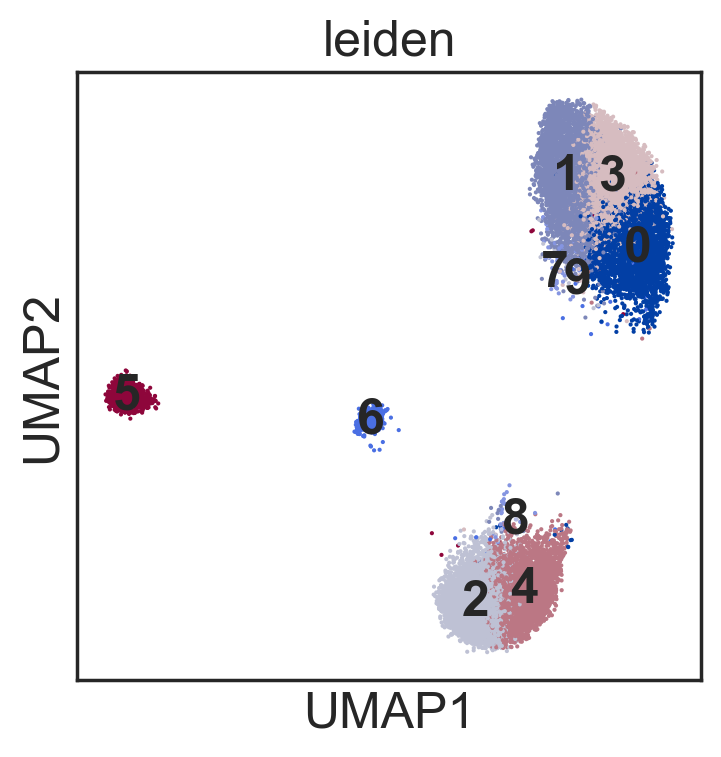

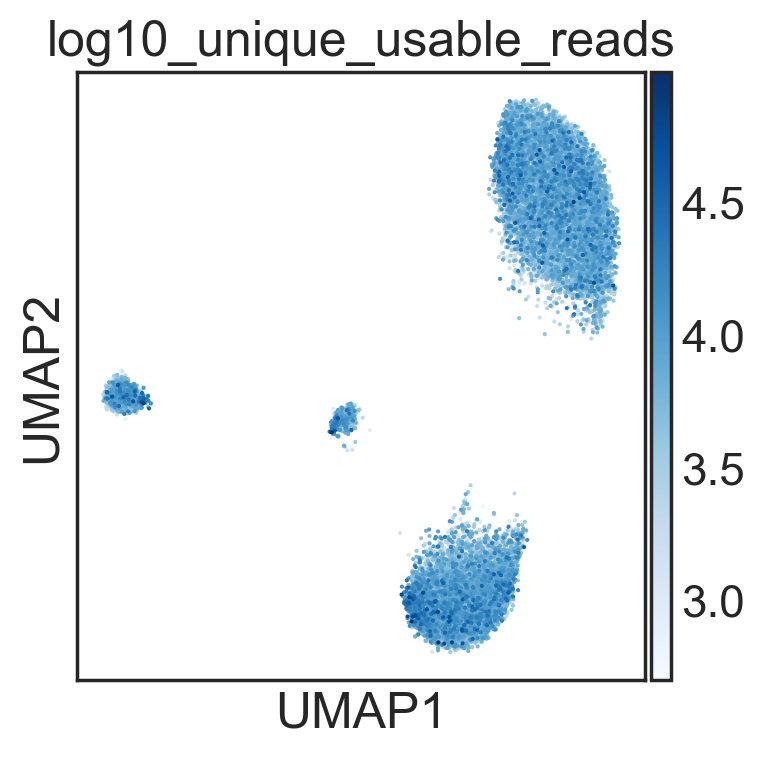

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


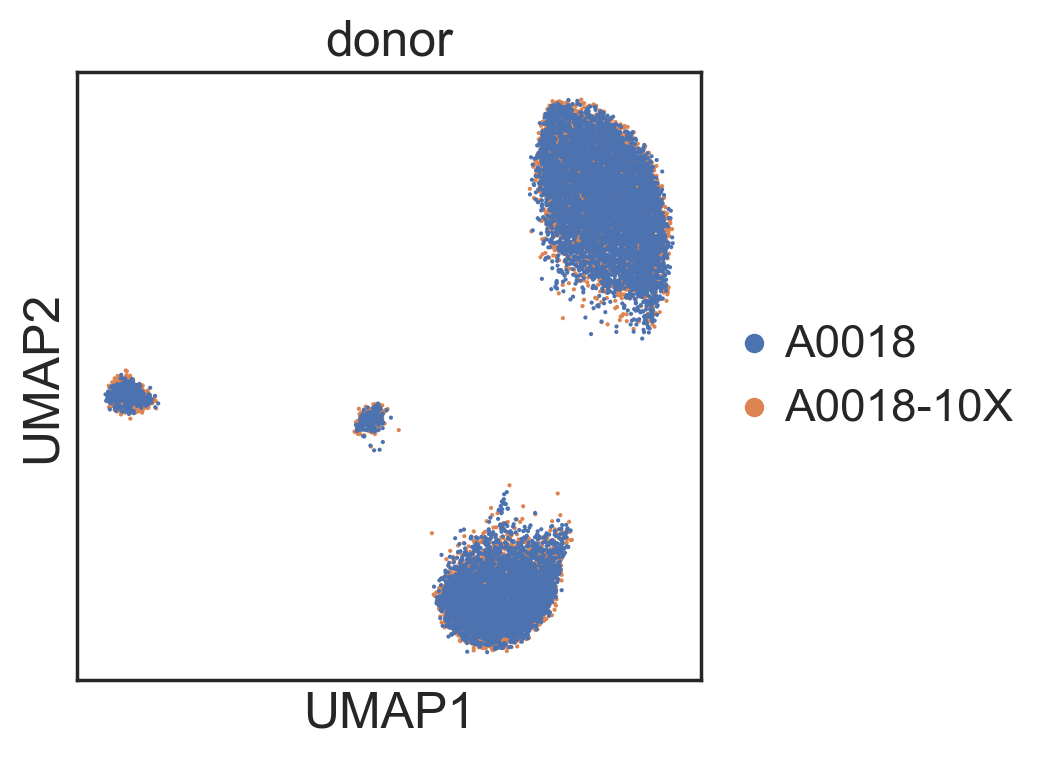

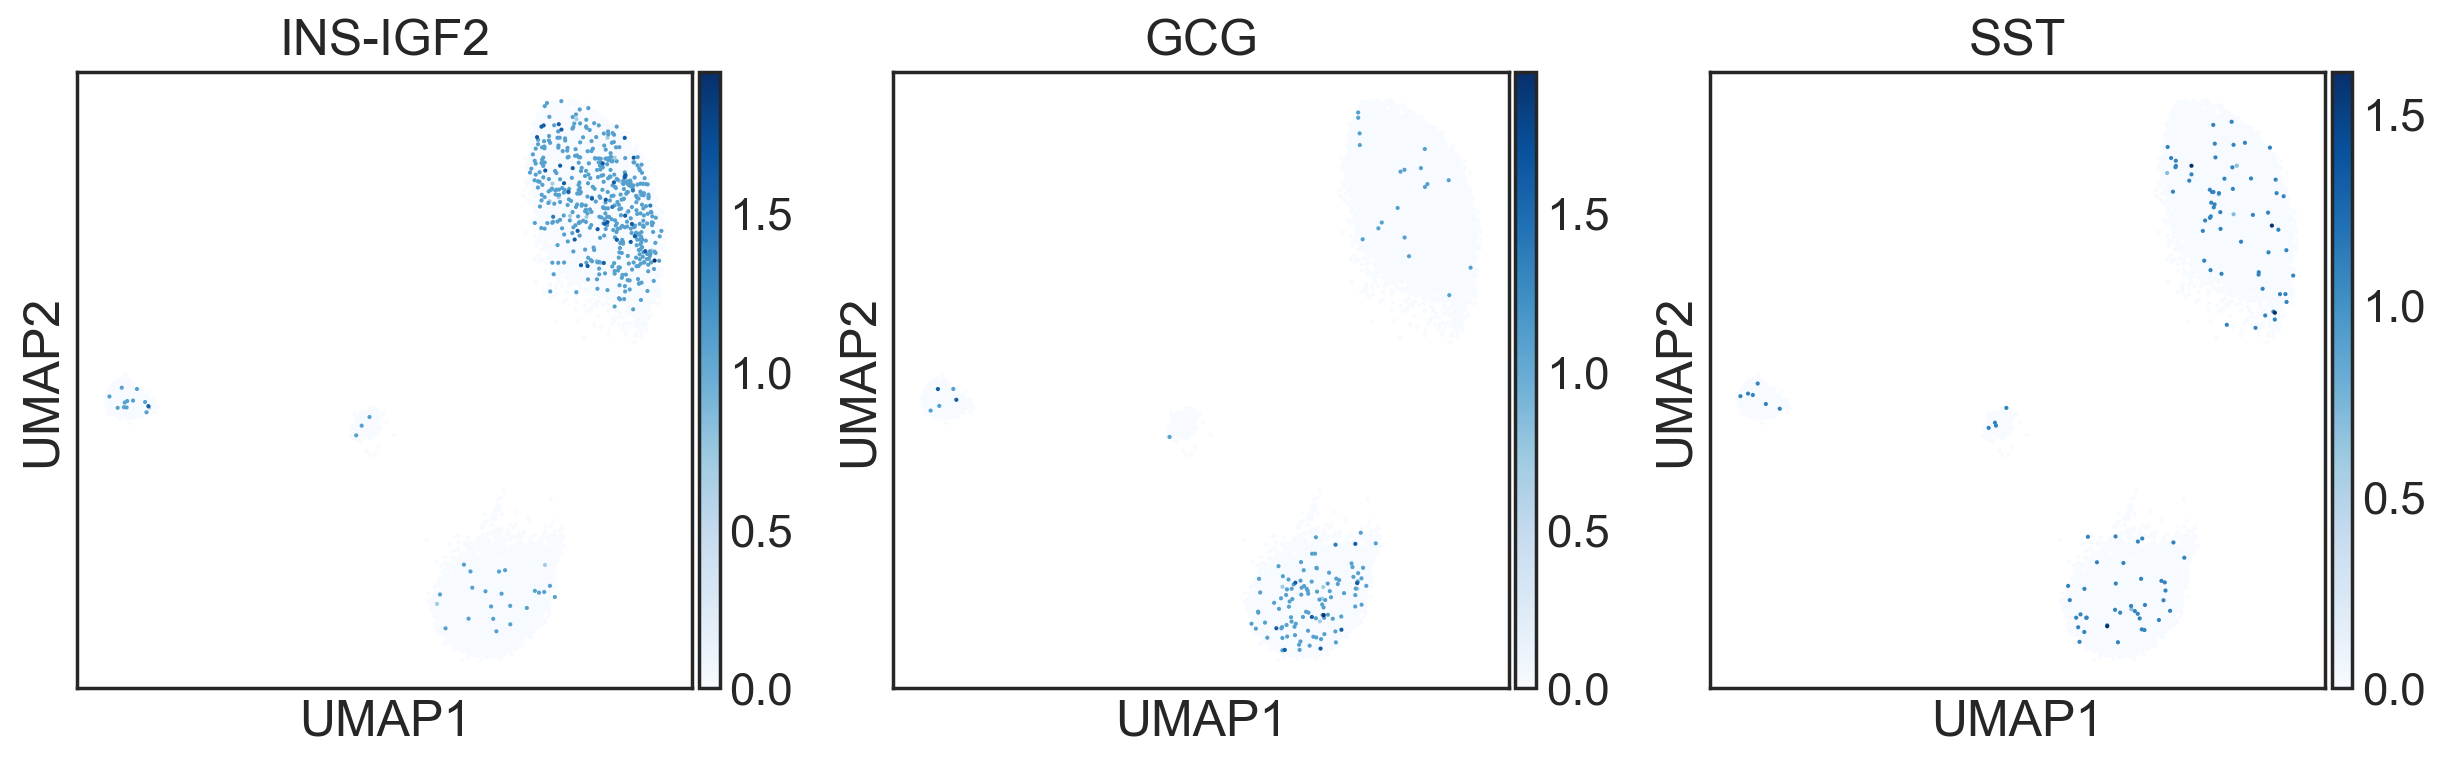

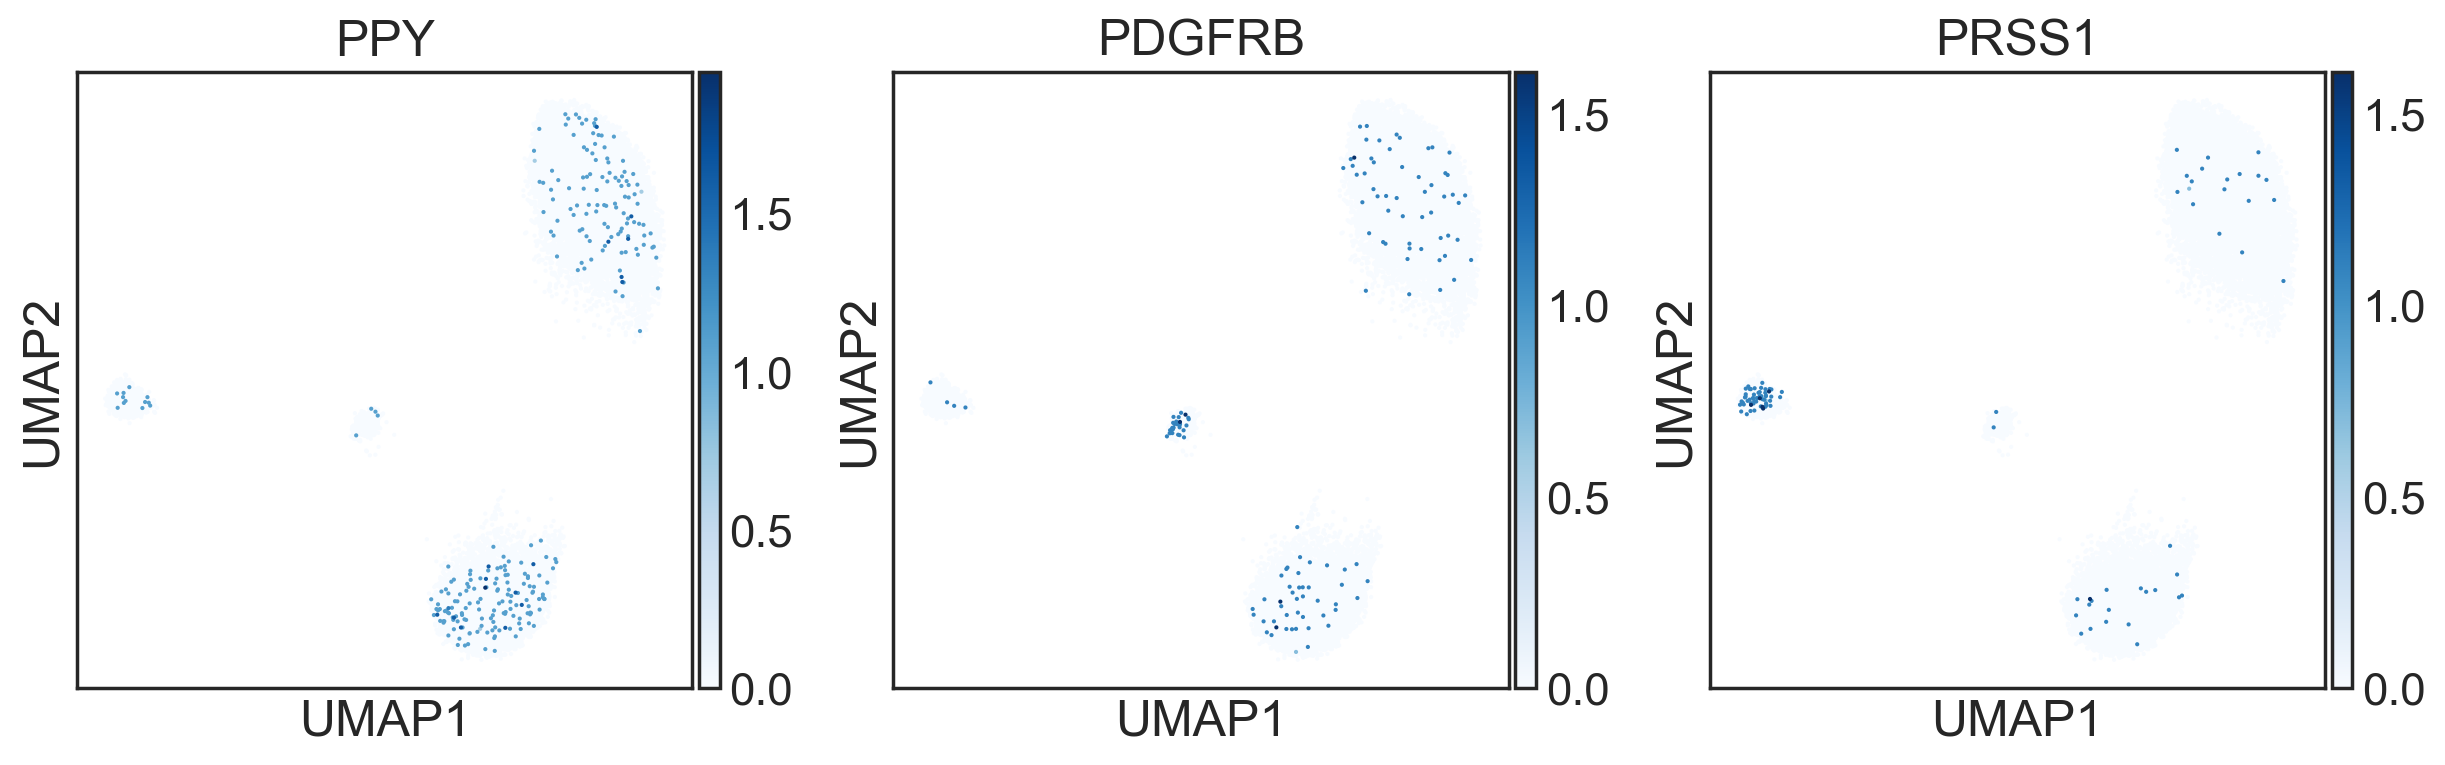

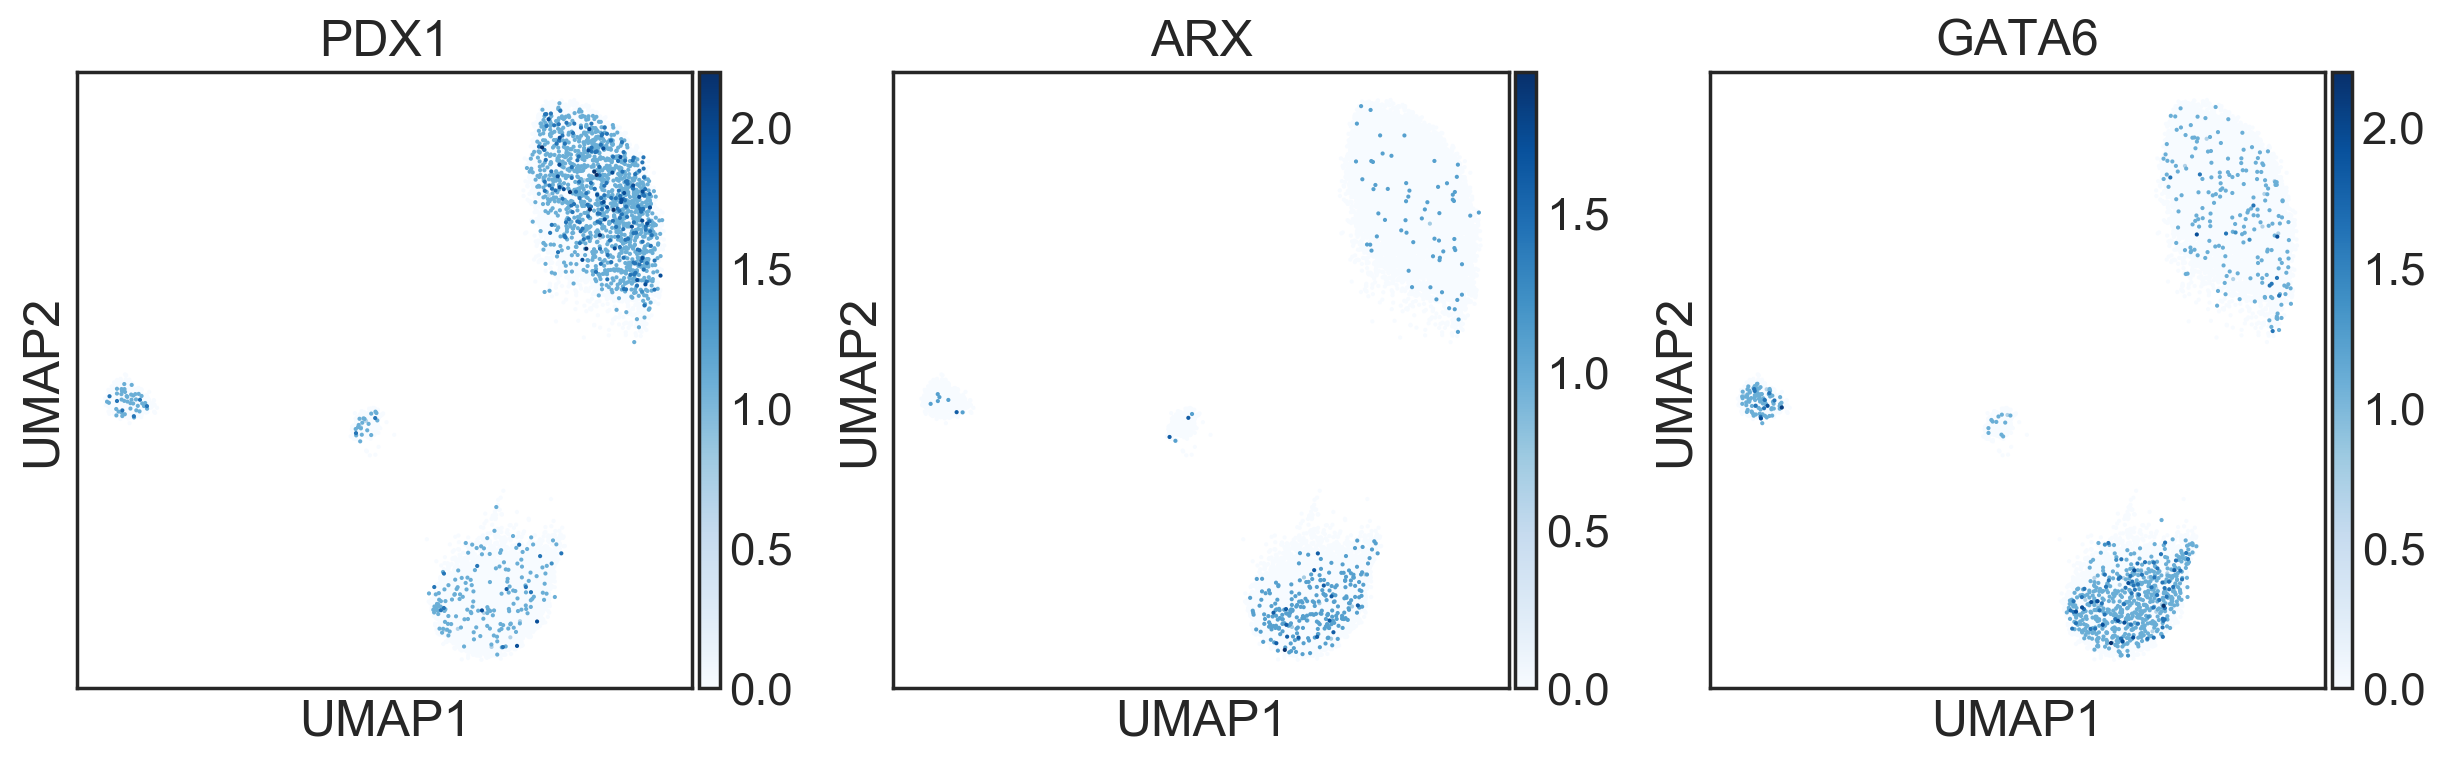

In [31]:
adata_norm.obsm['X_pca'] = harmonized.values
sc.pp.neighbors(adata_norm, n_neighbors=30, method='umap', metric='cosine', random_state=0, n_pcs=50)
sc.tl.leiden(adata_norm, resolution=1.25, random_state=0)
sc.tl.umap(adata_norm, min_dist=0.3, random_state=0)
sc.pl.umap(adata_norm, color=['leiden'], size=9, legend_loc='on data')
sc.pl.umap(adata_norm, color=['log10_unique_usable_reads'], size=9, color_map='Blues')
sc.pl.umap(adata_norm, color=['donor'], size=9)

sc.pl.umap(adata_norm, color=['INS-IGF2','GCG','SST'], size=9, color_map='Blues', use_raw=True)
sc.pl.umap(adata_norm, color=['PPY','PDGFRB','PRSS1'], size=9, color_map='Blues', use_raw=True)
sc.pl.umap(adata_norm, color=['PDX1','ARX','GATA6'], size=9, color_map='Blues', use_raw=True)

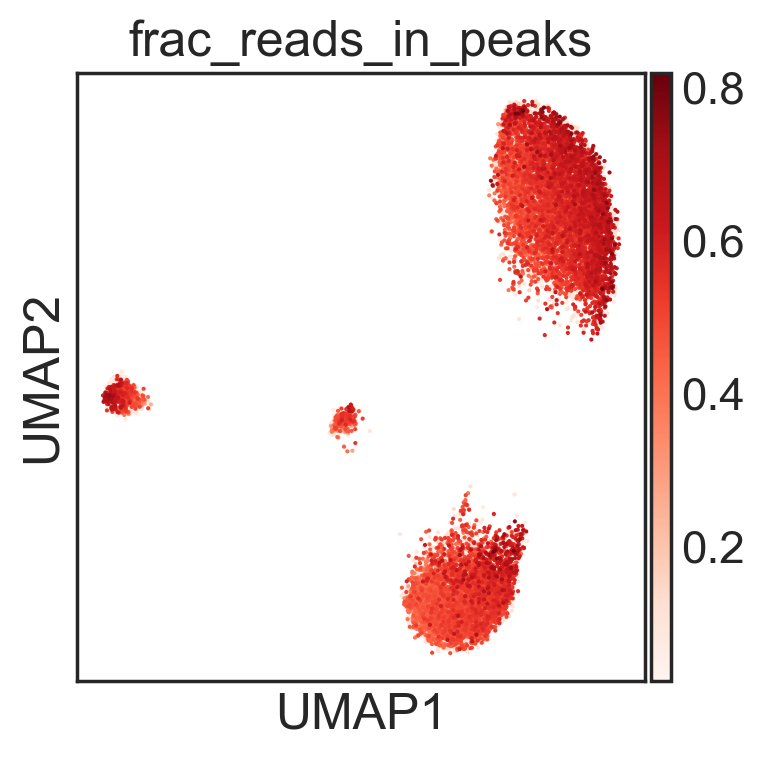

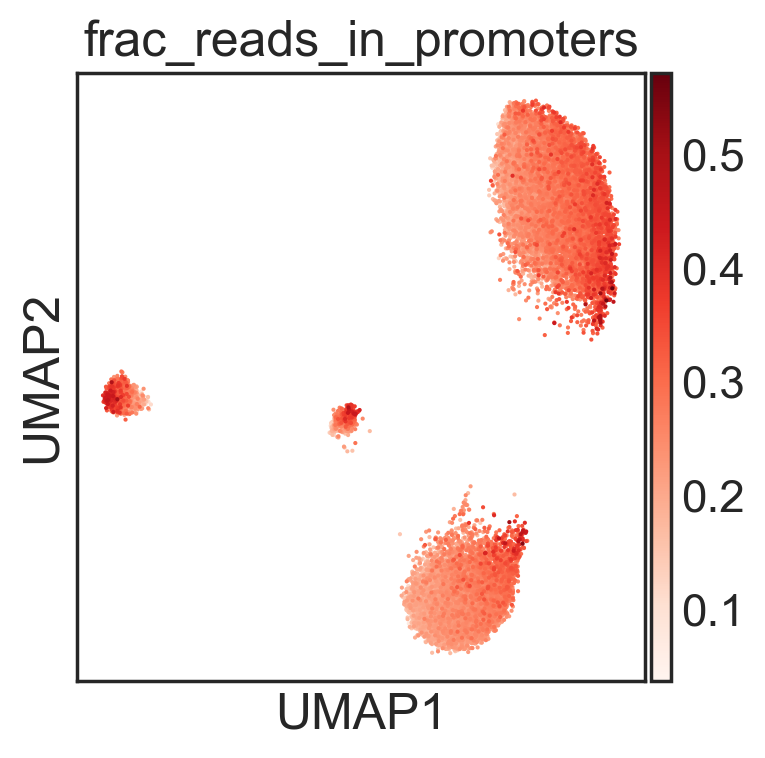

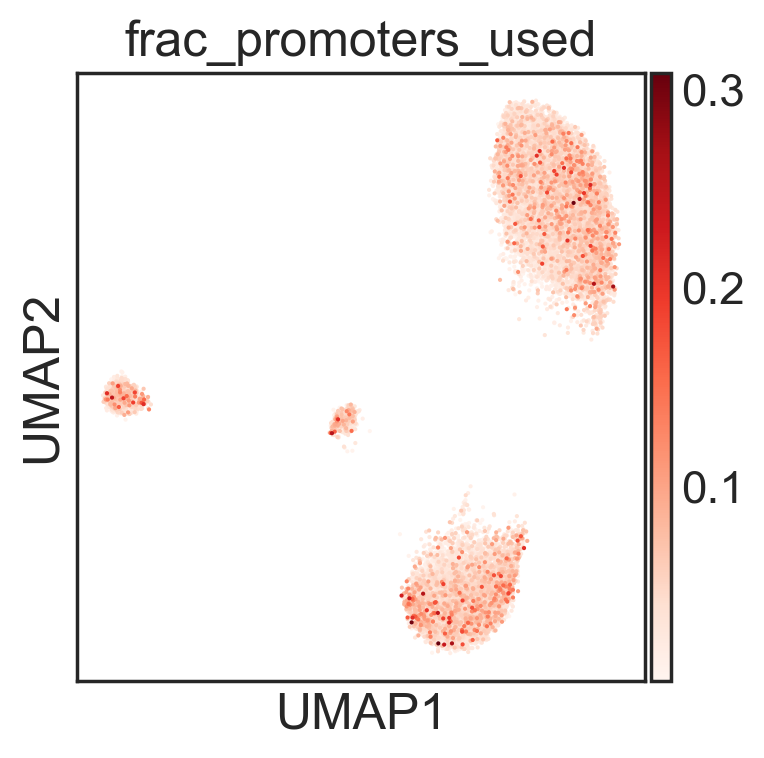

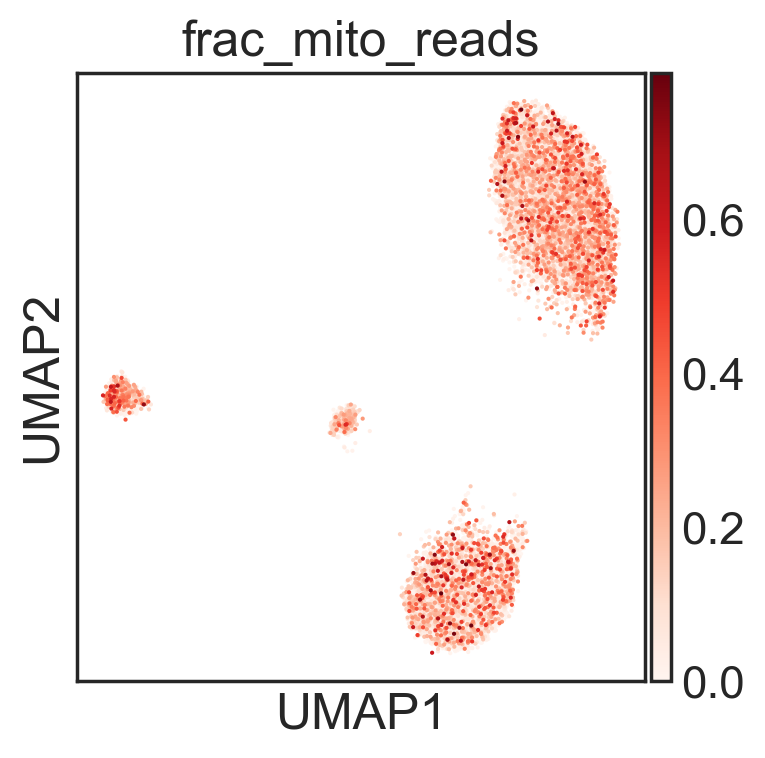

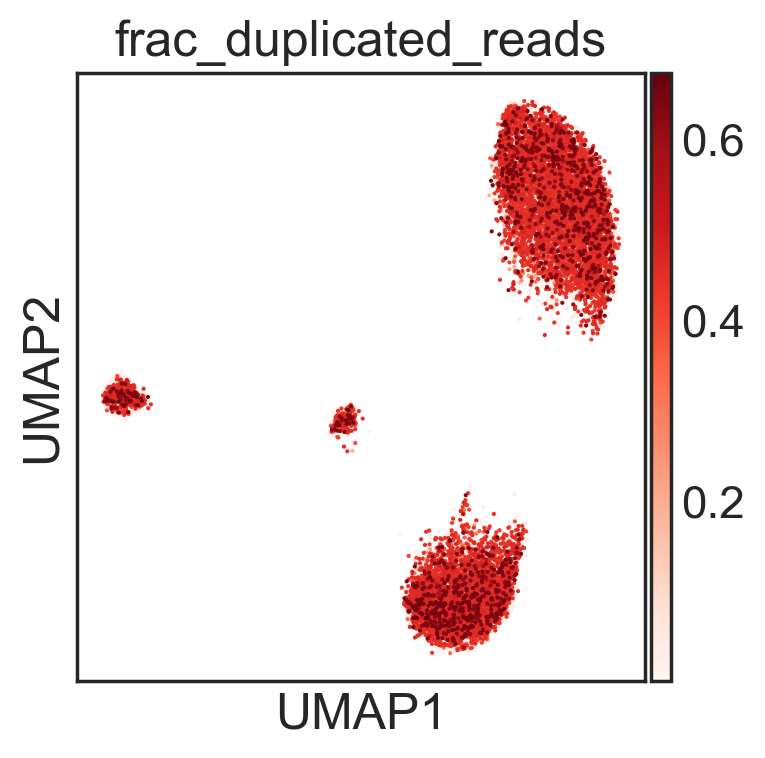

In [28]:
sc.pl.umap(adata_norm, color=['frac_reads_in_peaks'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata_norm, color=['frac_reads_in_promoters'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata_norm, color=['frac_promoters_used'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata_norm, color=['frac_mito_reads'], cmap='Reds', size=9, legend_loc='on data')
sc.pl.umap(adata_norm, color=['frac_duplicated_reads'], cmap='Reds', size=9, legend_loc='on data')